In [ ]:
import random as rnd
from typing import Union
import pandas as pd
import numpy as np

from typing import List
import matplotlib.pyplot as plt

In [ ]:
data_pd = pd.read_excel("data.xlsx", dtype={"player_number":np.intp})
data_pd["slot#"] = None

In [ ]:
def top_slice(roster: pd.DataFrame, slices:int, size:int) -> pd.DataFrame:
    roster_mean = roster["player_score"].mean()
    
    filter = roster["player_score"] > roster_mean
    
    selection = roster[filter]
    
    if selection.size < slices:
        slices = selection.size
    
    selection = selection.head(slices)
    
    selection.index = pd.RangeIndex(start=0, stop=len(selection.index), step=1)
    
    for i in range(0, len(selection.index)):
        selection.at[i, "slot#"] = i
        # selection.at[i, "player_division"] = f"top: {i}"
    
    return selection

def bottom_slice(roster: pd.DataFrame, slices:int, size:int) -> pd.DataFrame:
    roster_mean = roster["player_score"].mean()
    
    filter = roster["player_score"] <= roster_mean
    
    selection = roster.loc[filter]
    
    if selection.size <= slices:
        slices = selection.size
        
    selection = selection.tail(slices)
    
    selection.index = pd.RangeIndex(start=0, stop=len(selection.index), step=1)
    
    for i in range(0, len(selection.index)):
        selection.at[i, "slot#"] = i
        # selection.at[i, "player_division"] = f"bottom: {i}"
    
    return selection
        
def shuffle(roster: pd.DataFrame, slices:int, size:int) -> pd.DataFrame:
    
    sorted = roster.sort_values(by=["player_score"],axis=0, ascending=False)
    
    top    = top_slice(sorted, slices, size)
   
    bottom = bottom_slice(sorted, slices, size)
        
    selector = pd.concat( [top, bottom] ) 
    
    selector.index = pd.RangeIndex(start=0, stop=len(selector.index), step=1)
    
    rest = sorted.iloc[len(top.index)-1 : len(sorted.index) - len(bottom.index)]
    rest.index = pd.RangeIndex(start=0, stop=len(rest.index), step=1)
 
    shuffle = rest.sample(frac=1)
    
    for i in range(0, len(shuffle.index)):
        if shuffle.at[i, "slot#"] is None:
           shuffle.at[i, "slot#"] = rnd.randrange(0, size)
        #    shuffle.at[i, "player_division"] = f"rest {i}"
    
    data = pd.concat( [selector, shuffle] )
    data.index = pd.RangeIndex(start=0, stop=len(data.index), step=1)
    
    return data
    # return  selector

def slicer(data: pd.DataFrame, slices: int, size: int) -> pd.DataFrame:
    size = size - 1
    for i in range(0, ((slices * size) - size), size):
        slice = pd.DataFrame(data.iloc[i:i+size])
        yield slice

def generator(slices: int, size: int) -> List[pd.DataFrame]:
     teams = [i for i in slicer(shuffle(data_pd, slices, size), slices, size)]
     return teams
 
def solver(teams: int, players: int) -> Union[float, pd.DataFrame]:
    teams = generator(teams, players)
    means =[]
    for t in teams:
        t_mean = t["player_score"].mean()
        means.append( { "team": t.iloc[0]["slot#"], "mean": t_mean} )

    means_pd = pd.DataFrame(means)
    stdev = means_pd["mean"].std() # <-- minimize this
    return (stdev, teams)

In [ ]:
def main(itterations: int):
    league_teams = 8
    players_per_team = 7
    roster_mean = data_pd["player_score"].mean()

    min_min = itterations
    
    selection: List[pd.DataFrame] = None

    for i in range(0, min_min):
        std, teams = solver(league_teams, players_per_team)
        selection = teams
        if std < min_min:
            min_min = std
            pd.concat(teams).to_csv("./solution.csv")
            slots = pd.concat(teams)[["slot#", "player_score"]].groupby(["slot#"]).mean(["player_score"])
            slots.plot.bar(rot=0)
            plt.show()
            print(f"Itteration: {i} min: {min_min} roster_mean: {roster_mean}")
        
        
    print("roster_mean", roster_mean)
    print("min_min", min_min)

    solution = pd.concat(selection)
    solution.to_csv("./solution.csv")

    slots = solution[["slot#", "player_score"]].groupby(["slot#"]).mean(["player_score"])
    
    ax = slots.plot(kind="bar",  rot=0, animated=True,fill=False)
    ax.set_title("Distribution")
    plt.show()
    
    

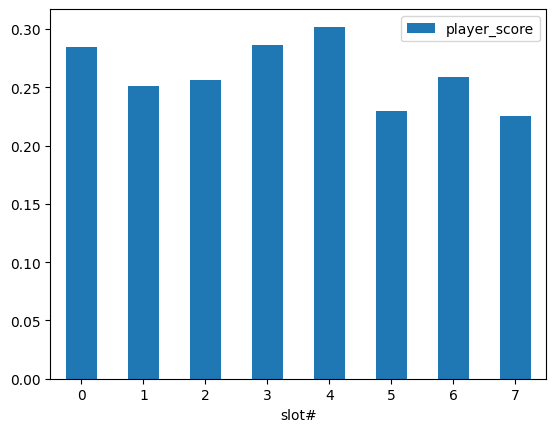

Itteration: 9535 min: 0.07177271592550159


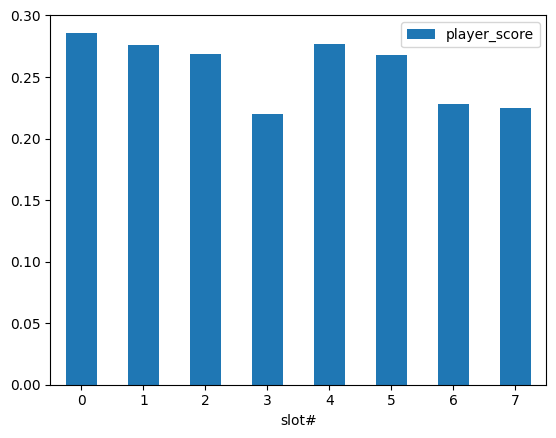

Itteration: 28165 min: 0.07174230043675538


In [116]:
 
# if __name__ == "__main__":
main(1000000)

